In [1]:
import os
import glob
import time
import datetime
import itertools as it
import numpy as np
from imageio import imwrite
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import torch.nn.parameter as P
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets

# Data preparation

In [2]:
img_path = "/home/md359230/DeepLearning/assignment2/data/cityscapes/*.png"
print(len(glob.glob(img_path)))

3475


In [3]:
base_path = "/home/md359230/DeepLearning/assignment2/data/cityscapes"
images = [file for file in os.listdir(base_path) if file.endswith(".png")]

In [4]:
np.random.shuffle(images)
train_images, test_images = images[:-500], images[-500:]

In [6]:
print(len(train_images), len(test_images))

2975 500


In [7]:
check_array = np.array(
    [[116, 17, 36],
     [152, 43,150],
     [106,141, 34],
     [ 69, 69, 69],
     [  2,  1,  3],
     [127, 63,126],
     [222, 52,211],
     [  2,  1,140],
     [ 93,117,119],
     [180,228,182],
     [213,202, 43],
     [ 79,  2, 80],
     [188,151,155],
     [  9,  5, 91],
     [106, 75, 13],
     [215, 20, 53],
     [110,134, 62],
     [  8, 68, 98],
     [244,171,170],
     [171, 43, 74],
     [104, 96,155],
     [ 72,130,177],
     [242, 35,231],
     [147,149,149],
     [ 35, 25, 34],
     [155,247,151],
     [ 85, 68, 99],
     [ 71, 81, 43],
     [195, 64,182],
     [146,133, 92]])

In [8]:
# Encoding in form of 1e6 * x + 1e3 * y + z -> id
label_encoding = {}
def encodeLabel(label):
    return label[0] * 1000000 + label[1] * 1000 + label[2]

for label_code, label in enumerate(check_array):
    label_encoding[encodeLabel(label)] = label_code

In [9]:
def process_images(images, base_path, target_path):
    counter = 0
    for image in images:
        counter += 1
        if counter % 100 == 0:
            print(counter)
        # Split image into raw image and class annotation
        data = plt.imread(os.path.join(base_path, image)) * 255
        raw_image, label = data[:, :256, :], data[:, 256:, :]

        raw_image = raw_image.astype('uint8')
        # Save class annotation as txt
        label = np.array([label_encoding[encodeLabel(label[x, y])] 
                          for x, y in it.product(range(256), range(256))])
        label = label.reshape(256, 256).astype('uint8')

        # Save training image and class annotation
        imwrite(os.path.join(target_path, image), raw_image)
        np.savetxt(os.path.join(target_path, image[:-4] + ".txt"), label, fmt="%d")

In [10]:
train_path = "/home/md359230/DeepLearning/assignment2/data/train"
process_images(train_images, base_path, train_path)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


In [11]:
test_path  = "/home/md359230/DeepLearning/assignment2/data/test"
process_images(test_images, base_path, test_path)

100
200
300
400
500


In [62]:
! ls /home/md359230/DeepLearning/assignment2/data/train | wc -l

5950


In [63]:
! ls /home/md359230/DeepLearning/assignment2/data/test | wc -l

1000


# Data loading

In [3]:
class CityScapesDataSet(Dataset):
    def __init__(self, root_dir, transform=None):
        self.examples = list(set(name[:-4] for name in os.listdir(root_dir)))
        self.example_number = len(self.examples)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return 2 * self.example_number

    def __getitem__(self, idx):
        
        rotate_image = idx + 1 > self.example_number
        img_name   = os.path.join(self.root_dir, self.examples[idx % self.example_number] + '.png')
        label_name = os.path.join(self.root_dir, self.examples[idx % self.example_number] + '.txt')
        
        data = plt.imread(img_name)
        label = np.loadtxt(label_name, dtype='int')
        
        if rotate_image:
            data  = np.flip(data, axis=1).copy()
            label = np.flip(label, axis=1).copy()
            
        if self.transform is not None:
            data = transform(data)
            label = torch.from_numpy(label)
            
        return data, label

In [8]:
dataset_path = '/home/md359230/DeepLearning/assignment2/data/train'
validation_path = '/home/md359230/DeepLearning/assignment2/data/test'

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [10]:
csds = CityScapesDataSet(dataset_path, transform)

In [11]:
csdsval = CityScapesDataSet(validation_path, transform)

In [12]:
dataloader = DataLoader(csds,
                        batch_size=16,
                        shuffle=True,
                        num_workers=8)

In [156]:
%%time
for i, batch in enumerate(dataloader):
    if i % 100 == 0:
        print(len(batch), batch[0].size(), batch[1].size())

2 torch.Size([128, 3, 256, 256]) torch.Size([128, 256, 256])
CPU times: user 108 ms, sys: 1.15 s, total: 1.26 s
Wall time: 54.3 s


In [8]:
print(len(csds))

5950


# U-Net implementation

In [17]:
class UNetConvolutionStack(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(UNetConvolutionStack, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, 
                      out_channel, 
                      kernel_size=3, 
                      padding=1),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU()
        )
    
    def forward(self, x):
        x = self.conv(x)
        return x

In [18]:
class EncoderStack(nn.Module):
    def __init__(self, in_channel, out_channel, first_layer=False):
        super(EncoderStack, self).__init__()
        if first_layer:
            self.down = nn.Sequential(
                UNetConvolutionStack(in_channel,
                                     out_channel),
                UNetConvolutionStack(out_channel,
                                     out_channel)
            )            
        else:
            self.down = nn.Sequential(
                nn.MaxPool2d((2,2)),
                UNetConvolutionStack(in_channel,
                                     out_channel),
                UNetConvolutionStack(out_channel,
                                     out_channel)
            )    
            
    def forward(self, x):
        x = self.down(x)
        return x

In [19]:
class DecoderStack(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(DecoderStack, self).__init__()
        self.upsample = nn.ConvTranspose2d(in_channel , in_channel, 3, stride=2, padding=1)
        self.up = nn.Sequential(
            UNetConvolutionStack(in_channel + out_channel,
                                 out_channel),
            UNetConvolutionStack(out_channel,
                                 out_channel)
        )    
    def forward(self, x, y):
        x = self.upsample(x, output_size=y.size())
        x = torch.cat([y, x], dim=1)
        x = self.up(x)
        return x

In [20]:
class UNet(nn.Module):
    def __init__(self, encoder_channels, decoder_channels):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.conv = nn.Conv2d(decoder_channels[-1], 
                              30, 
                              kernel_size=3, 
                              padding=1)
    
        encoder_sizes = zip(range(len(encoder_channels)), encoder_channels, encoder_channels[1:])
        for idx, in_size, out_size in encoder_sizes:
            if idx > 0:
                self.encoder.append(EncoderStack(in_size, out_size))
            else:
                self.encoder.append(EncoderStack(in_size, out_size, first_layer=True))
         
        decoder_sizes = zip(decoder_channels, decoder_channels[1:])
        for in_size, out_size in decoder_sizes:
            self.decoder.append(DecoderStack(in_size, out_size))    
            
    def forward(self, x):
        encoded_layers = []
        for e in self.encoder:
            x = e(x)
            encoded_layers.append(x)
        
        del encoded_layers[-1]
        #print([m.size() for m in encoded_layers])
        encoded_layers.reverse()
        
        for y, d in zip(encoded_layers, self.decoder):
            x = d(x, y)
            
        x = self.conv(x)
        return x

# U-Net training

In [144]:
class UNetTrainer(object):
    def __init__(self, trainLoader, testLoader):
        self.trainLoader = trainLoader
        self.testLoader = testLoader

    def validate(self, net, use_gpu=False, device=None):
        correct = 0
        total = 0
        
        validation_size = len(self.testLoader) // 2
        for idx in range(validation_size):
            image, label = self.testLoader[idx]
            flipped_image, flipped_label = self.testLoader[idx + validation_size]
            image = image.unsqueeze(0)
            flipped_image = flipped_image.unsqueeze(0)
            
            if device is not None and (device.__str__() != "cpu") and use_gpu:
                image, label = image.to(device), label.to(device)  
                flipped_image, flipped_label = flipped_image.to(device), flipped_label.to(device) 
                
            output = net(image)
            flipped_output = net(flipped_image)
            data = (output.data.squeeze() + torch.flip(flipped_output.data.squeeze(), [2])) / 2
            
            _, predicted = torch.max(data, 0)
            response = (label + torch.flip(flipped_label, [1])) / 2
            
            total += response.size()[0] * response.size()[1]
            correct += (predicted == response).sum().item()
                
        print('Accuracy of the network on {} test images: {:2.4f} %'.format(
        validation_size, 100 * correct / total))   
        
    def assess(self,  net, use_gpu=False, device=None):
        correct = 0
        total = 0
        loader = self.trainLoader
        for data in loader:
            images, labels = data
            if device is not None and (device.__str__() != "cpu") and use_gpu:
                images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size()[0] * labels.size()[1] * labels.size()[2]
            correct += (predicted == labels).sum().item()
        
        print('Accuracy of the network on {} train images: {:2.4f} %'.format(
        len(self.trainLoader.dataset), 100 * correct / total))     
           
    def train(self, config, n_epoch=5, use_gpu=False):
        net = UNet(**config)
        
        if use_gpu:
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            if device.__str__() != "cpu":
                net.to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.0002, amsgrad=True)

        for epoch in range(n_epoch):
            running_loss = 0.0
            t = time.time()
            net.train()
            
            for i, data in enumerate(self.trainLoader, 0):
                inputs, labels = data
                
                if use_gpu:
                    if(device.__str__() != "cpu"):
                        inputs, labels = inputs.to(device), labels.to(device)
                    
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                if i % 10 == 9:
                    now = datetime.datetime.now()
                    print('[%s , %d, %5d] Loss: %.4f' %
                          (now.strftime('%Y-%m-%d %H:%M:%S'), epoch + 1, i + 1, running_loss / 100))
                    print('[%s , %d, %5d] Elapsed time: %2.4f s' %
                          (now.strftime('%Y-%m-%d %H:%M:%S'), epoch + 1, i + 1, time.time() - t))
                    running_loss = 0.0
                    t = time.time()
            net.eval()
            
            self.assess(net, use_gpu=use_gpu, device=device)
            self.validate(net, use_gpu=True, device=device)
        return net

In [145]:
config = {
    "encoder_channels": [3, 32, 64, 128, 256, 512], 
    "decoder_channels": [512, 256, 128,64,32]
}

In [146]:
trainer = UNetTrainer(dataloader, csdsval)
model = trainer.train(config, n_epoch=5, use_gpu=True)

[2019-05-07 22:59:54 , 1,    10] Loss: 0.3264
[2019-05-07 22:59:54 , 1,    10] Elapsed time: 5.3046 s
[2019-05-07 22:59:57 , 1,    20] Loss: 0.2939
[2019-05-07 22:59:57 , 1,    20] Elapsed time: 3.2109 s
[2019-05-07 23:00:01 , 1,    30] Loss: 0.2676
[2019-05-07 23:00:01 , 1,    30] Elapsed time: 3.2068 s
[2019-05-07 23:00:04 , 1,    40] Loss: 0.2493
[2019-05-07 23:00:04 , 1,    40] Elapsed time: 3.2148 s
[2019-05-07 23:00:07 , 1,    50] Loss: 0.2287
[2019-05-07 23:00:07 , 1,    50] Elapsed time: 3.2265 s
[2019-05-07 23:00:10 , 1,    60] Loss: 0.2144
[2019-05-07 23:00:10 , 1,    60] Elapsed time: 3.2224 s
[2019-05-07 23:00:14 , 1,    70] Loss: 0.1975
[2019-05-07 23:00:14 , 1,    70] Elapsed time: 3.2455 s
[2019-05-07 23:00:17 , 1,    80] Loss: 0.1912
[2019-05-07 23:00:17 , 1,    80] Elapsed time: 3.2383 s
[2019-05-07 23:00:20 , 1,    90] Loss: 0.1754
[2019-05-07 23:00:20 , 1,    90] Elapsed time: 3.2515 s
[2019-05-07 23:00:23 , 1,   100] Loss: 0.1685
[2019-05-07 23:00:23 , 1,   100] Ela

In [147]:
trainer = UNetTrainer(dataloader, csdsval)
trainer.validate(model, use_gpu=True, device=device)

26359927 32768000 0.8044411315917969
Accuracy of the network on 500 test images: 80.4441 %


# Unit testing

In [81]:
np.loadtxt(os.path.join(train_path, '367.txt'), dtype='int')

array([[ 4, 24,  4, ...,  4,  4,  4],
       [ 4,  3, 24, ..., 27, 27, 24],
       [24,  3,  3, ..., 16, 16, 24],
       ...,
       [24, 26, 26, ...,  6, 28,  1],
       [24,  3,  3, ...,  1,  5, 11],
       [ 4, 24,  4, ..., 24, 11, 24]])

In [82]:
np.allclose(np.loadtxt(os.path.join(train_path, '367.txt'), dtype='int'), label)

True

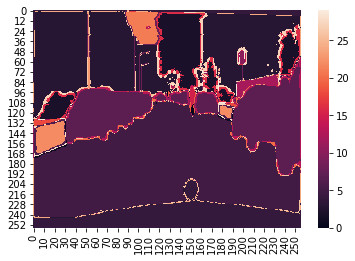

In [20]:
test = np.loadtxt(os.path.join(train_path, '0002.txt'), dtype='int')
import seaborn as sns
sns.heatmap(test)

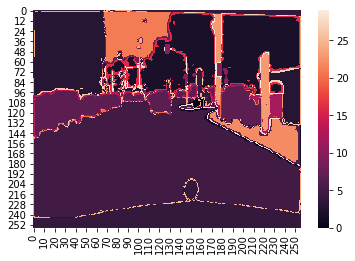

In [21]:
test = np.loadtxt(os.path.join(test_path, '0007.txt'), dtype='int')
import seaborn as sns
sns.heatmap(test)

In [75]:
csds = CityScapesDataSet(dataset_path)

In [76]:
csds.transform is not None

False

In [77]:
len(os.listdir(dataset_path))

5950

In [82]:
data, label = csds[5950 // 2]

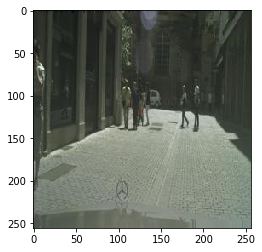

In [83]:
plt.imshow(data)

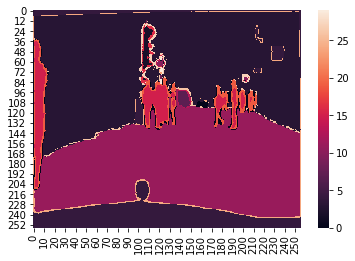

In [84]:
sns.heatmap(label)

In [42]:
for i, sample in enumerate(dataloader):
    data, label = sample
    if i == 0:
        break

In [146]:
downsample = nn.Conv2d(3, 16, 3, stride=2, padding=1)
downsample2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
upsample = nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1)

In [147]:
data.size()

torch.Size([8, 3, 256, 256])

In [148]:
data_intermediate = downsample(data)
data_intermediate.size()

torch.Size([8, 16, 128, 128])

In [149]:
data_down = downsample2(data_intermediate)
data_down.size()

torch.Size([8, 32, 64, 64])

In [150]:
data_up = upsample(data_down, output_size=data_intermediate.size())
data_up.size()

torch.Size([8, 32, 128, 128])

In [156]:
data_cat = torch.cat([data_intermediate, data_up], dim=1)
data_cat.size()

torch.Size([8, 48, 128, 128])

In [157]:
ds = DecoderStack(32, 16)
ds(data_down, data_intermediate).size()

torch.Size([8, 16, 128, 128])

In [20]:
net = UNet([3, 32, 64, 128, 256, 512], [512, 256, 128,64,32])

In [21]:
data, label = next(iter(dataloader))

In [22]:
data.size()

torch.Size([16, 3, 256, 256])

In [23]:
net(data).size()

[torch.Size([16, 32, 256, 256]), torch.Size([16, 64, 128, 128]), torch.Size([16, 128, 64, 64]), torch.Size([16, 256, 32, 32])]


torch.Size([16, 30, 256, 256])

In [105]:
b = torch.arange(4).view(2,2)

In [106]:
b

tensor([[0, 1],
        [2, 3]])

In [109]:
torch.flip(b, [1])

tensor([[1, 0],
        [3, 2]])

In [110]:
a = torch.arange(8).view(2, 2, 2)

In [111]:
a

tensor([[[0, 1],
         [2, 3]],

        [[4, 5],
         [6, 7]]])

In [114]:
torch.flip(a, [2])

tensor([[[1, 0],
         [3, 2]],

        [[5, 4],
         [7, 6]]])